# Modeling The Spread of The Coronavirus in the United States <a class="anchor" id="top"></a>

**By Ellek Linton**

*B.A. in Data Science (2020) from the University of California, Berkeley*

*Published: March 27, 2020 (6pm MST)*

*Last Updated: April 1, 2020 (6pm MST)*

This is my attempt to understand the spread of the coronavirus in the only way I know how: with data. I am modeling the total number of cases and deaths in the United States of COVID-19. This analysis references open-source COVID-19 data from [John Hopkins University](https://github.com/CSSEGISandData/COVID-19) and world population data from the [United Nations](https://population.un.org/wpp/Download/Standard/Population/). This analysis will be updated daily at 6pm MST (GMT 00:00) daily.

I will attempt to model the spread of the novel Coronavirus (COVID-19) in the United States and around the world. Except for the imported libraries (`numpy`, `pandas`, `matplotlib`), I built all of the code used in this analysis and model 100% from scratch, inlcuding the regression model.

This analysis is open source, and all of the code used is available on [Github](https://github.com/elleklinton/covid19). This latest analysis is also available as a webpage: https://elleklinton.com/covid19

### My Predictions For Total Number of Confirmed COVID-19 Cases (USA):

| Date | Predicted Total Cases | Actual Total Cases | Error (%) |
| --- | --- | --- | --- |
|[March 27, 2020](https://elleklinton.com/covid19/2020-03-27.html)|100,157|101,657|- 1.476%|
|[March 28, 2020](https://elleklinton.com/covid19/2020-03-28.html)|123,451|121,478|+ 1.624%|
|[March 29, 2020](https://elleklinton.com/covid19/2020-03-29.html)|143,471|140,886|+ 1.835%|
|[March 30, 2020](https://elleklinton.com/covid19/2020-03-30.html)|170,697|161,807|+ 5.494%|
|[March 31, 2020](https://elleklinton.com/covid19/2020-03-31.html)|189,826|188,172| + 0.879%|
|[April 01, 2020](https://elleklinton.com/covid19/2020-04-01.html)|221,710|213,372|+ 3.908%|
|[April 02, 2020](https://elleklinton.com/covid19/index.html)|242,828|243,453|-0.257%|
|April 03, 2020|274,533|-|-|
|April 04, 2020|304,321|-|-|
|April 05, 2020|335,060|-|-|
|April 06, 2020|366,024|-|-|
|April 07, 2020|399,607|-|-|

# Table of Contents:
### 1. [Import Libraries](#1)

### 2. [Load Data](#2)
- [Get Coronavirus Data](#2a)
- [Get World Population Data](#2b)

### 3. [Process and Clean Data](#3)
- [Standardize Coronavirus Data](#3a)
- [Standardize World Population Data](#3b)
- [Match World Population Data With Coronavirus Data](#3c)

### 4. [Prepare Data For Modeling](#4)
- [Designing Data](#4a)

### 5. [Calibrating Model To Predict Number of Cases In The United States](#5)
- [Generating Training/Validation Data](#5a)
- [Threshold Tuning](#5b)
- [Window Size Tuning](#5c)
- [Lambda Tuning](#5d)

### 6. [Calibrating Model To Predict Number of Deaths In The United States](#6)
- [Threshold Tuning](#6a)
- [Window Size Tuning](#6b)
- [Lambda Tuning](#6c)

### 7. [Predicting Total Number of Cases in The United States](#7)
- [Growth Equation](#7a)
- [Levelling Off](#7b)

### 8. [Predicting Total Number of Deaths in The United States](#8)

### 9. [Visualizations and Further Analysis](#9)
- [Plotting Fraction of Population Infected](#9a)
- [Plotting Relative Growth Curves](#9b)

# 1: Import Libraries <a class="anchor" id="1"></a>
[Return to top](#top)

For the core model, I will be using a ridge linear regression model that I built from scratch.

In [1]:
from datetime import datetime, timedelta
from dateutil import tz
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
from Regression import RidgeRegression
import warnings

rcParams['figure.figsize'] = 9, 5

# 2: Load Data <a class="anchor" id="2"></a>
[Return to top](#top)

I am using open-source data from [John Hopkins University](https://github.com/CSSEGISandData/COVID-19) to get the daily number of COVID-19 confirmed cases and number of deaths. I am using [United Nations](https://population.un.org/wpp/Download/Standard/Population/) data to get world population data.

The Coronavirus data is updated daily at 6pm MST (GMT 00:00) daily. I am attempting to place a lower-bound on the number of reported coronavirus cases in the United States.

### Get Coronavirus Data <a class="anchor" id="2a"></a>

In [2]:
deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [3]:
confirmed_cases = pd.read_csv(confirmed_cases_url)
deaths = pd.read_csv(deaths_url)

Let's take a look at what the `confirmed_cases` actually looks like:

In [4]:
confirmed_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


And this is the `deaths` data:

In [5]:
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1,2,4,4,4,4,4,4,4,6
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,5,5,6,8,10,10,11,15,15,16
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,19,21,25,26,29,31,35,44,58,86
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,1,1,3,3,3,6,8,12,14,15
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,0,0,2,2,2,2,2


### Get World Population Data <a class="anchor" id="2b"></a>

In [6]:
world_pop = pd.read_csv("World Population.csv")

The `world_pop` data is a bit messy, so I am going to clean it up in [step 3](#3b). This is what the `world_pop` data looks like:

In [7]:
world_pop.head()

,"Region, subregion, country or area *",Notes,Country code,Type,Parent code,1950,1951,1952,1953,1954,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,WORLD,NaN,900,World,0,2536431.02,2584034.23,2630861.69,2677609.06,2724846.75,...,7041194.17,7125827.96,7210582.04,7295290.76,7379796.97,7464021.93,7547858.90,7631091.11,7713468.21,7794798.73
1,More developed regions,b,901,Development Group,1803,814818.91,824003.51,833720.17,843787.54,854060.46,...,1239557.45,1244114.53,1248453.53,1252615.11,1256622.19,1260478.67,1264146.38,1267558.90,1270630.32,1273304.26
2,Less developed regions,c,902,Development Group,1803,1721612.11,1760030.72,1797141.52,1833821.52,1870786.30,...,5801636.72,5881713.43,5962128.51,6042675.65,6123174.78,6203543.27,6283712.52,6363532.21,6442837.89,6521494.47
3,Least developed countries,d,941,Development Group,902,195427.79,199180.39,203015.20,206985.64,211133.08,...,856471.44,876867.23,897793.44,919222.96,941131.32,963519.72,986385.40,1009691.25,1033388.87,1057438.16
4,"Less developed regions, excluding least develo...",e,934,Development Group,902,1526184.32,1560850.33,1594126.32,1626835.88,1659653.21,...,4945165.28,5004846.19,5064335.07,5123452.69,5182043.46,5240023.55,5297327.12,5353840.96,5409449.02,5464056.31


# 3. Process and Clean Data <a class="anchor" id="3"></a>
[Return to top](#top)

Since I am using two separate data sources for population and coronavirus data, I have to do some data cleaning to ensure that the two properly match up with one another. Some of the country names differ between the two datasets, and the two are formatted slightly differently. I am also going to standardize both datasets by setting the country as the row index for both of them.

### Standardize Coronavirus Data <a class="anchor" id="3a"></a>

Below, I am summing up the total for each country for each day, and dropping the Latitude and Longitude data, since we don't need it here.

In [8]:
deaths_clean = deaths.groupby("Country/Region").sum().drop(["Lat", "Long"], axis=1)
confirmed_cases_clean = confirmed_cases.groupby("Country/Region").sum().drop(["Lat", "Long"], axis=1)
confirmed_cases_clean.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
Albania,0,0,0,0,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
Algeria,0,0,0,0,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
Andorra,0,0,0,0,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
Angola,0,0,0,0,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


### Standardize World Population Data <a class="anchor" id="3b"></a>

Since we are only concerned with 2020 population data, I am dropping all of the other columns in the dataset. I am also setting the country as the row index so the data matches the standard format.

In [9]:
world_pop_clean = world_pop.loc[:, [world_pop.columns[0], "2020"]].copy()#world_pop[[world_pop.columns[0], "2020"]]
world_pop_clean["2020"] *= 1000
world_pop_clean = world_pop_clean.set_index("Region, subregion, country or area *")
world_pop_clean.columns = ["2020 Population"]
world_pop_clean.head()

,2020 Population
"Region, subregion, country or area *",
WORLD,7.794799e+09
More developed regions,1.273304e+09
Less developed regions,6.521494e+09
Least developed countries,1.057438e+09
"Less developed regions, excluding least developed countries",5.464056e+09


### Match World Population Data With Coronavirus Data <a class="anchor" id="3c"></a>

Some of the country names are different between the World Population data and the Coronavirus data. So I am going to standardize the columns of the Coronavirus data to match the World Population data. First, I will create a dictionary mapping the Coronavirus country names to the World Population country names for the countries that differ in their name. Some of the Coronavirus countries are not in the World Population dataset, so I am going to drop those countries from the coronavirus dataset.

In [10]:

coronaToPopulation = {
    "Bolivia" : "Bolivia (Plurinational State of)",
    "Brunei" : "Brunei Darussalam",
    "Congo (Brazzaville)" : None,
    "Congo (Kinshasa)" : None,
    "Cote d'Ivoire" : None,
    "Diamond Princess" : None,
    "Iran" : "Iran (Islamic Republic of)",
    "Korea, South" : "Republic of Korea",
    "Laos" : None,
    "Moldova" : "Republic of Moldova",
    "Russia" : "Russian Federation",
    "Syria" : "Syrian Arab Republic",
    "Taiwan*" : "China, Taiwan Province of China",
    "Tanzania" : "United Republic of Tanzania",
    "West Bank and Gaza" : None,
    "US" : "United States of America",
    "Venezuela" : "Venezuela (Bolivarian Republic of)",
    "Vietnam" : "Viet Nam",
    "Kosovo" : None,
    "Burma" : None
}

missingCountries = list(confirmed_cases_clean.index[[c not in world_pop_clean.index for c in confirmed_cases_clean.index]])

for m in missingCountries:
    if m not in coronaToPopulation.keys():
        coronaToPopulation[m] = None

Now, I am going to correct the names of country in the Coronavirus datasets:

In [11]:
assert np.all(deaths_clean.index == confirmed_cases_clean.index), "Death data and confirmed cases data have different indices!"
coronaIndex = list(confirmed_cases_clean.index)
for k, v in coronaToPopulation.items():
    try:
        coronaIndex[coronaIndex.index(k)] = v
    except:
        pass

Finally, I am going to set the new country index and drop the rows from the Coronavirus datasets that do not have a corresponding country in the World Population data. I am also going to drop the cases that have no cases of Coronavirus from the Coronavirus dataset. The final cleaned dataset is displayed below.

In [12]:
confirmed_cases_clean.index = coronaIndex
deaths_clean.index = coronaIndex

confirmed_cases_clean = confirmed_cases_clean.loc[pd.isna(confirmed_cases_clean.index) == False, :]
deaths_clean = deaths_clean.loc[pd.isna(deaths_clean.index) == False, :]

confirmed_cases_clean = confirmed_cases_clean[np.sum(confirmed_cases_clean, axis=1) > 1]
deaths_clean = deaths_clean[np.sum(deaths_clean, axis=1) > 1]

confirmed_cases_clean.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,74,84,94,110,110,120,170,174,237,273
Albania,0,0,0,0,0,0,0,0,0,0,...,123,146,174,186,197,212,223,243,259,277
Algeria,0,0,0,0,0,0,0,0,0,0,...,264,302,367,409,454,511,584,716,847,986
Andorra,0,0,0,0,0,0,0,0,0,0,...,164,188,224,267,308,334,370,376,390,428
Angola,0,0,0,0,0,0,0,0,0,0,...,3,3,4,4,5,7,7,7,8,8


In [13]:
confirmed_cases_clean.loc["United States of America"]

1/22/20         1
1/23/20         1
1/24/20         2
1/25/20         2
1/26/20         5
            ...  
3/29/20    140886
3/30/20    161807
3/31/20    188172
4/1/20     213372
4/2/20     243453
Name: United States of America, Length: 72, dtype: int64

Let's run a quick test to make sure all of the Coronavirus countries have corresponding populations now:

In [14]:
assert np.all([c in world_pop_clean.index for c in confirmed_cases_clean.index]), "A country in confirmed_cases_clean is not in the world_pop_clean! Investigate further."
assert np.all([c in world_pop_clean.index for c in deaths_clean.index]), "A country in deaths_clean is not in the world_pop_clean! Investigate further."
print("All Coronavirus countries properly match with the World Population data! Safe to proceed.")

All Coronavirus countries properly match with the World Population data! Safe to proceed.


# 4. Prepare Data For Modeling <a class="anchor" id="4"></a>
[Return to top](#top)

### Designing Data <a class="anchor" id="4a"></a>

I am going to model the spread of Coronavirus as a time-series. I will first create a function that turns a country from the tabled data into a set of time-series.

An example datapoint is:

---

|Input Data|Output Data|
|--|--|
|<table> <tr><th>Day_1</th><th>Day_2</th><th>Day_3</th><th>Day_4</th></tr><tr><td>2 cases</td><td>4 cases</td><td>7 cases</td><td>15 cases</td></tr> </table>| <table> <tr><th>Day_5</th></tr><tr><td>30 cases</td></tr> </table>|

---


In the above example datapoint, I would attempt to predict the `Day_5` using [`Day_1`, `Day_2`, `Day_3`, `Day_4`] as inputs. The `windowSize` of the above data would be 4.


First, I need to construct methods to normalize/scale our data. In the preprocessing phase, I am going to divide each datapoint by the total population of that country. This will allow all countries to be represented on the same scale, even if their populations are different. So in this sense, under the hood, I will be predicting total percentage infected in a country.

In [15]:
def normalize(data, populations, country):
    assert country in populations.index, f"{country} is not in the World Populations dataset!"
    
    country_population = populations.loc[country][0]
    data = data / country_population
    return data

def reverseNormalize(data, populations, country):
    assert country in populations.index, f"{country} is not in the World Populations dataset!"
    
    country_population = populations.loc[country][0]
    data = data * country_population
    return data

In [16]:
def countryToData(baseTable, country="Italy", threshold=1, windowSize=4, shouldNormalize=True):
    assert country in list(baseTable.index), f"Invalid Country: {country}"
    windowSize += 1
    row = baseTable.loc[country]
    if not np.any(row >= threshold):
        return None
    y = np.array(row[np.argmax(row >= threshold):])
    if len(y) <= windowSize:
        return None
    X = []
    for i in range(len(y) - windowSize):
        window = y[i:i+windowSize]
        X.append(window)
    if shouldNormalize:
        return normalize(np.array(X), world_pop_clean, country)
    return np.array(X)

`countryToData` will take a country from the Coronavirus dataset, and convert it into data formatted like above. If a `threshold` is specified, `countryToData` will only output data AFTER at least `threshold` number of cases were present. This allows us to filter out many of the all-zero datapoints. If there are not enough values for `country` that satisfy the `threshold` requirement, `countryToData` will return `None`.

For example, let's print out a datapoint for total number of cases using data from Italy:

In [17]:
countryToData(confirmed_cases_clean, 
              country="Italy", 
              threshold=1, 
              windowSize=4, 
              shouldNormalize=False)[30]

array([1694, 2036, 2502, 3089, 3858])

In this example from Italy, we would want to predict `3858` total cases using [`1694`, `2036`, `2502`, `3089`] as inputs.

Now, let's build a function that generates data from multiple countries so we can train a model.

In [18]:
def generateData(baseTable, trainCountries=[], valCountries=["Italy"], threshold=1, windowSize=4, exclude=[]):
    if len(trainCountries) == 0:
        trainCountries = list(set(baseTable.index) - set(valCountries))
    train = None
    val = None
    
    for country in trainCountries + valCountries:
        countryData = countryToData(baseTable, country, threshold=threshold, windowSize=windowSize)
        if countryData is None or country in exclude:
            continue
        if country in trainCountries:
            if train is None:
                train = countryData
            else: 
                train = np.vstack((train, countryData))
        if country in valCountries:
            if val is None:
                val = countryData
            else:
                val = np.vstack((val, countryData))
    return train, val

`generateData` will generate two sets of data: training data and validation data. The function parameters are:

- `baseTable`: the table to generate data from. Either `confirmed_cases_clean` or `deaths_clean`.


- `trainCountries`: countries to train our model on. If an empty list (`[]`) is passed for this argument, the entire dataset (except for `valCountries`) will be used (e.g. train a model using the entire world's data).


- `valCountries`: countries we want to test our model on. If we want to train a model to predict the number of cases in Italy, using data from China, for example, `trainCountries` would be `["China"]` and `valCountries` would be `["Italy"]`


- `threshold`: Only take data from countries AFTER the country has reached `threshold` number of cases or deaths. This allows us to filter out the many datapoints that would be entirely zero.


- `windowSize`: how many preceding days we are using for datapoint. E.g. if we want to use the last 4 days as a prediction for the 5th day, `windowSize` would be `4`.

I am also going to define functions to normalize the data. These functions will take the natural log of the data, so we can project the exponentially growing number of cases into a linear space that can be accurately modeled by a regression classifier:

In [19]:
def logSafe(data, base=np.e):
    return np.log(np.clip(data, 1e-15, 1)) / np.log(base)

def expSafe(data, base=np.e):
    return base ** data

# 5. Calibrating Model To Predict Number of Cases In The United States <a class="anchor" id="5"></a>
[Return to top](#top)

### Generating Training/Validation Data <a class="anchor" id="5a"></a>

Now that I have the data pipeline configured, let's create our design matrices of training and validation data. I am going to attempt to predict the **total number of cases in the United States using the entire world as training data**. The last row of the `val` data is printed below. Keep in mind, this data has been normalized (divided by the total population of its country), so the `train` and `val` data represent the *fraction* of the total popualtion that is infected.

In [20]:
countryToPredict = "United States of America"

train_data_cases, val_data_cases = generateData(confirmed_cases_clean, 
                          trainCountries=[], 
                          valCountries=[countryToPredict], 
                          threshold=1, 
                          windowSize=4)

Now that I have some data to model, let's create a sample model and evaluate its performance and predictions. 

As an additional preprocessing step, I am going to take the natural log of the data. Since the growth of Coronavirus appears to be exponential, to predict it with a Linear Model, we need to project the data into linear space. By taking the natural log of each datapoint, we can predict the number of infected people (an exponential distribution) with a relatively simple and interpretable Linear Model.

In [21]:
model = RidgeRegression(inputFunction = logSafe, 
                        outputFunction = lambda data: reverseNormalize(expSafe(data), 
                                                                       world_pop_clean, 
                                                                       countryToPredict))

model.train(train_data_cases)
todayPred = model.predict(val_data_cases[-1,1:])[0]
print(f"This example model predicted that today, The United States would have {int(todayPred)} total cases of Coronavirus.")

This example model predicted that today, The United States would have 241575 total cases of Coronavirus.


Since I want to minimize the error of predictions for the total number of cases in the United States, we want to pick the `threshold` and `windowSize` that minimize the error of our predictions, and a `lambda` value for our regression to prevent overfitting. I will define the function below to calculate the loss (error) of our model:

In [22]:
def loss(model, val_data, country="United States of America", metric="mae", n=3):
    prediction = model.predict(val_data[:, :-1])[-n]
    truth = val_data[-n:,-1]
    truth = reverseNormalize(truth, world_pop_clean, country)
    if metric == "mse":
        return np.mean((truth - prediction)**2)
    elif metric == "mae":
        return np.mean(np.abs(truth - prediction))

loss(model, val_data_cases)

26191.215725386854

That is the loss (error) of our current model. MSE error means, on average, our model is +/- the above value for predicting the next day's number of total cases. We can do better than that. Let's build another function that computes the trains a model and computes the loss for a set of parameters, and then find the parameters that minimize that function:

Note: Since the earlier data is less predictable, and since I want to maximize the accuacy for the *latest* Coronavirus data to make predictions about the future, I am only going to test our model on the last `n` data observations.

In [23]:
def scoreParameters(baseTable=confirmed_cases_clean, country="United States of America", 
                    threshold=1, windowSize=15, lmb=1e-5, metric="mae", n=3, logBase=np.e):
    train_data, val_data = generateData(baseTable, 
                              trainCountries=[], 
                              valCountries=[country], 
                              threshold=threshold, 
                              windowSize=windowSize)
#     print(train_data)
    
    model = RidgeRegression(inputFunction = lambda data: logSafe(data, logBase), 
                            outputFunction = lambda data: reverseNormalize(expSafe(data, logBase), 
                                                                           world_pop_clean, 
                                                                           country))
    model.train(train_data, lmb=lmb)
    return loss(model, val_data, country, metric, n)

Since I am optimizing 3 hyperparameters (`threshold`, `windowSize`, and `lambda`), I am going to optimize each parameter, one at a time, whilst holding the others constant. First, let's create a function to help us visualize the loss for each hyperparameter value:

In [24]:
def visualize(values_tested, losses, param, xLog=False):
    plt.plot(values_tested, losses, label="Loss")
    plt.xlabel(f"Values of {param}")
    plt.ylabel(f"Loss")
    if xLog: plt.xscale("log")
    plt.title(f"Testing Different Values of {param}")
    plt.show()

### Threshold Tuning <a class="anchor" id="5b"></a>

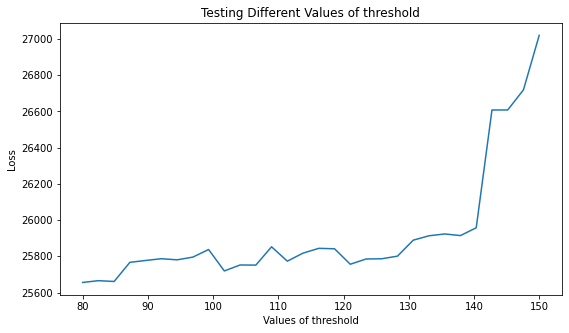

The best threshold found was 80.0 with a loss of 25655.626064941112


In [25]:
thresholds_to_test = list(np.linspace(80, 150, 30))
threshold_losses = []
for t in thresholds_to_test:
    threshold_loss = scoreParameters(threshold=t, lmb=0)
    threshold_losses.append(threshold_loss)

best_threshold_i = np.argmin(threshold_losses)
best_threshold_cases = thresholds_to_test[best_threshold_i]
visualize(thresholds_to_test, threshold_losses, "threshold")

print(f"The best threshold found was {best_threshold_cases} with a loss of {threshold_losses[best_threshold_i]}")

### Window Size Tuning <a class="anchor" id="5c"></a>

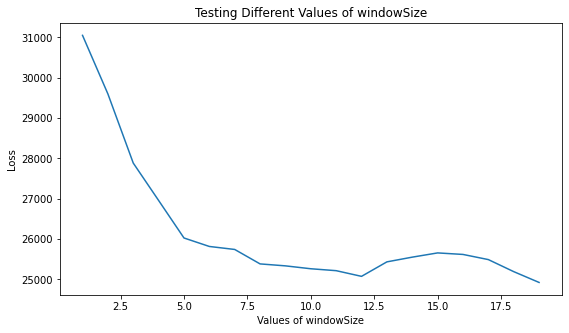

The best windowSize found was 19 with a loss of 24923.395883994486


In [26]:
windowSizes_to_test = list(range(1,20))
windowSize_losses = []
for w in windowSizes_to_test:
    windowSize_loss = scoreParameters(threshold=best_threshold_cases, windowSize=w, lmb=0)
    windowSize_losses.append(windowSize_loss)

best_windowSize_i = np.argmin(windowSize_losses)
best_windowSize_cases = windowSizes_to_test[best_windowSize_i]
visualize(windowSizes_to_test, windowSize_losses, "windowSize")

print(f"The best windowSize found was {best_windowSize_cases} with a loss of {windowSize_losses[best_windowSize_i]}")

### Lambda Tuning <a class="anchor" id="5d"></a>

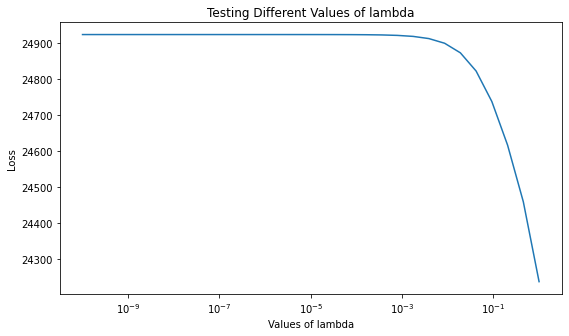

The best lambda found was 1.0 with a loss of 24236.394252081238


In [27]:
lmb_to_test = list(np.geomspace(1e-10, 1e-0, 30))
lmb_losses = []
for l in lmb_to_test:
    lmb_loss = scoreParameters(threshold=best_threshold_cases, windowSize=best_windowSize_cases, lmb=l)
    lmb_losses.append(lmb_loss)

best_lmb_i = np.argmin(lmb_losses)
best_lmb_cases = lmb_to_test[best_lmb_i]
visualize(lmb_to_test, lmb_losses, "lambda", True)

print(f"The best lambda found was {best_lmb_cases} with a loss of {lmb_losses[best_lmb_i]}")

# 6. Calibrating Model To Predict Number of Deaths In The United States <a class="anchor" id="6"></a>
[Return to top](#top)

### Threshold Tuning <a class="anchor" id="6a"></a>

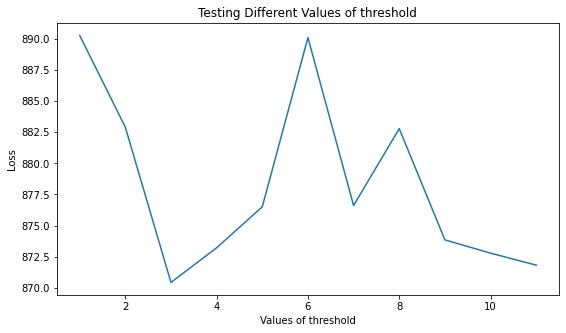

The best threshold found was 3 with a loss of 870.4360353071894


In [28]:
thresholds_to_test = list(range(1,12))
threshold_losses = []
for t in thresholds_to_test:
    threshold_loss = scoreParameters(deaths_clean, threshold=t, lmb=0)
    threshold_losses.append(threshold_loss)

best_threshold_i = np.argmin(threshold_losses)
best_threshold_deaths = thresholds_to_test[best_threshold_i]
visualize(thresholds_to_test, threshold_losses, "threshold")

print(f"The best threshold found was {best_threshold_deaths} with a loss of {threshold_losses[best_threshold_i]}")

### Window Size Tuning <a class="anchor" id="6b"></a>

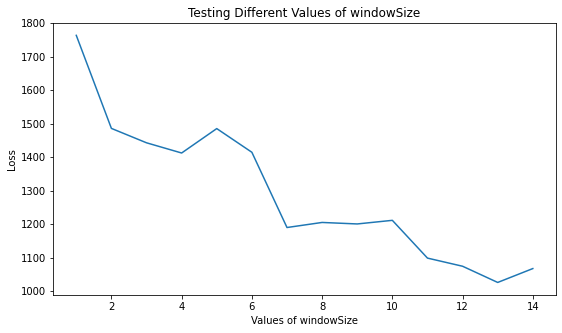

The best windowSize found was 13 with a loss of 1025.8603621057623


In [29]:
windowSizes_to_test = list(range(1,15))
windowSize_losses = []
for w in windowSizes_to_test:
    windowSize_loss = scoreParameters(deaths_clean, threshold=1, windowSize=w, lmb=0.1)
    windowSize_losses.append(windowSize_loss)

best_windowSize_i = np.argmin(windowSize_losses)
best_windowSize_deaths = windowSizes_to_test[best_windowSize_i]
visualize(windowSizes_to_test, windowSize_losses, "windowSize")

print(f"The best windowSize found was {best_windowSize_deaths} with a loss of {windowSize_losses[best_windowSize_i]}")

### Lambda Tuning <a class="anchor" id="6c"></a>

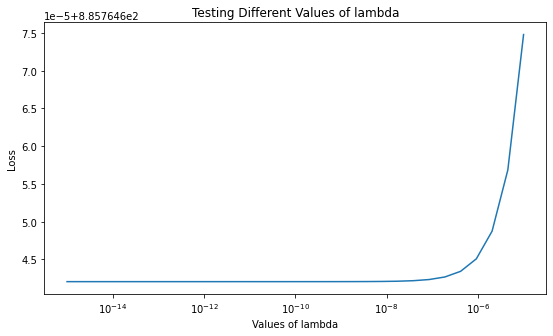

The best lambda found was 1.1721022975334794e-13 with a loss of 885.7646420433265


In [30]:
lmb_to_test = list(np.geomspace(1e-15, 1e-5, 30))
lmb_losses = []
for l in lmb_to_test:
    lmb_loss = scoreParameters(deaths_clean, threshold=best_threshold_deaths, windowSize=best_windowSize_deaths, lmb=l)
    lmb_losses.append(lmb_loss)

best_lmb_i = np.argmin(lmb_losses)
best_lmb_deaths = lmb_to_test[best_lmb_i]
visualize(lmb_to_test, lmb_losses, "lambda", True)

print(f"The best lambda found was {best_lmb_deaths} with a loss of {lmb_losses[best_lmb_i]}")

# 7. Predicting Total Number of Cases in The United States <a class="anchor" id="7"></a>
[Return to top](#top)

At this point, I have generated sufficient data and tuned our model hyperparameters to minimize loss (error). I am now ready to create a final model to predict the number of future cases of the Coronavirus in the United States. Let's build a function to predict multiple days into the future using the latest available data:

In [31]:
def predict(model, baseTable=confirmed_cases_clean, windowSize=5, daysToPredict=5, country="United States of America"):
    pop = world_pop_clean.loc[country][0]
    data = baseTable.loc[country, :][-windowSize:] / pop
    predictions = []
    while len(predictions) < daysToPredict:
        nextData = data[-windowSize:]
        nextPred = model.predict(nextData)[0]
        predictions.append(nextPred)
        data = np.append(data, normalize(nextPred, world_pop_clean, country))
    return predictions

And let's also define a couple utility functions to help us display our predictions neatly:

In [32]:
def timeFormatter(daysInFuture=1):
    latestFromData = datetime.strptime(confirmed_cases_clean.columns[-1], "%m/%d/%y")
    latestFromData = latestFromData.replace(tzinfo=tz.gettz('UTC'))
    locTime = latestFromData.astimezone(tz.tzlocal()) + timedelta(days=daysInFuture + 1)
    return locTime.strftime("%b %d, %Y, %l:%M%p")

def printPredictions(preds, suffix="total cases of Coronavirus in The United States."):
    for i in range(len(preds)):
        p = preds[i]
        i += 1
        s = f"On {timeFormatter(i)}: I predict {int(p):,} {suffix}\n"
        print(s)

First, I will generate our data using the optimal hyperparameters that we discovered in steps [5](#5) and [6](#6):

In [33]:
countryToPredict = "United States of America"

train_data_cases, val_data_cases = generateData(confirmed_cases_clean, 
                          trainCountries=[], 
                          valCountries=[countryToPredict], 
                          threshold=best_threshold_cases, 
                          windowSize=best_windowSize_cases)

Next, I will construct and train our model to predict the total number of cases:

In [34]:
total_cases_model = RidgeRegression(inputFunction = logSafe, 
                                    outputFunction = lambda data: reverseNormalize(expSafe(data), 
                                                                                   world_pop_clean, 
                                                                                   countryToPredict))
total_cases_model.train(train_data_cases, lmb=best_lmb_cases)

I have now created and trained a model to predict the number of total cases of the Coronavirus in the United States. We can predict the total number of cases over the next five days:

In [35]:
total_cases_predictions = predict(total_cases_model, confirmed_cases_clean, best_windowSize_cases, daysToPredict=5)

printPredictions(total_cases_predictions)

On Apr 03, 2020,  6:00PM: I predict 274,533 total cases of Coronavirus in The United States.

On Apr 04, 2020,  6:00PM: I predict 304,321 total cases of Coronavirus in The United States.

On Apr 05, 2020,  6:00PM: I predict 335,060 total cases of Coronavirus in The United States.

On Apr 06, 2020,  6:00PM: I predict 366,024 total cases of Coronavirus in The United States.

On Apr 07, 2020,  6:00PM: I predict 399,607 total cases of Coronavirus in The United States.



### Growth Equation <a class="anchor" id="7a"></a>

Since I am using a transformed linear model, we can interpret the learned model weights as the rate of growth of COVID-19 as a function of the total count of cases over the preceeding days.

In [36]:
def latexifyExponent(base="e",exp="exponent"):
    return f"{base}^{{{exp}}}"

def buildLatexEquation(weights, decimals=4):
    s = ""
    bias = weights[0]
    s += f"P^{{{round(-sum(weights[1:]), decimals)}}}*{latexifyExponent('e', round(bias, decimals))}"
    weights = weights[1:]
    weight_sum = sum(weights[1:])
    for i in range(len(weights)):
        i = len(weights) - i - 1
        s += latexifyExponent(f"*X_{{{len(weights) - i}}}", round(weights[i], decimals))
    return s

First, we need to define the augmented data that we will be working with:

- ***$X_i$ = number of cases $i$ days ago*** (in the United States)

    - *For example, $X_1$ would be the number of cases 1 day ago (yesterday) and $X_2$ would be the number of cases two days ago.*
    

- ***$P$ = population of the target country***


****The prediction for tomorrow's number of cases can be approximated by:****

In [37]:
display(Latex("$X_{{Tomorrow}} = $"))
display(Latex(f"${buildLatexEquation(total_cases_model.w)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

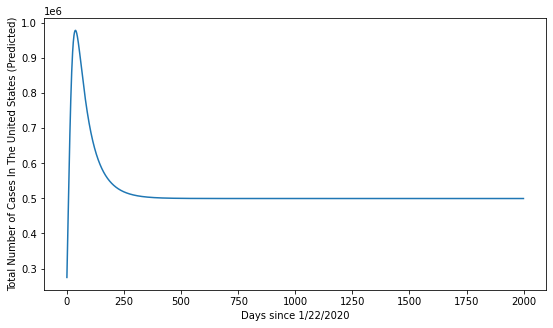

In [38]:
daysToPlot = 2000
plt.plot(list(range(daysToPlot)), predict(total_cases_model, confirmed_cases_clean, best_windowSize_cases, daysToPredict=daysToPlot))
plt.xlabel("Days since 1/22/2020")
plt.ylabel("Total Number of Cases In The United States (Predicted)")
plt.show()

### Levelling Off <a class="anchor" id="7b"></a>

In [39]:
# If you particularly want to display maths, this is more direct:
display(Latex('$$\\frac{1}{2}$$'))

<IPython.core.display.Latex object>

# 8. Predicting Total Number of Deaths in The United States <a class="anchor" id="8"></a>
[Return to top](#top)

I am now going to predict the total number of deaths in the United States from Coronavirus using the model hyperparameters trained in steps [5](#5) and [6](#6).

In [40]:
countryToPredict = "United States of America"

train_data_deaths, val_data_deaths = generateData(deaths_clean, 
                          trainCountries=[], 
                          valCountries=[countryToPredict], 
                          threshold=best_threshold_deaths, 
                          windowSize=best_windowSize_deaths)

In [41]:
total_deaths_model = RidgeRegression(inputFunction = logSafe, 
                                    outputFunction = lambda data: reverseNormalize(expSafe(data), 
                                                                                   world_pop_clean, 
                                                                                   countryToPredict))
total_deaths_model.train(train_data_deaths, lmb=best_lmb_deaths)

In [42]:
death_preds = predict(total_deaths_model, deaths_clean, best_windowSize_deaths, daysToPredict=5)

printPredictions(death_preds, suffix="total deaths from Coronavirus in The United States.")

On Apr 03, 2020,  6:00PM: I predict 7,033 total deaths from Coronavirus in The United States.

On Apr 04, 2020,  6:00PM: I predict 8,298 total deaths from Coronavirus in The United States.

On Apr 05, 2020,  6:00PM: I predict 9,710 total deaths from Coronavirus in The United States.

On Apr 06, 2020,  6:00PM: I predict 11,355 total deaths from Coronavirus in The United States.

On Apr 07, 2020,  6:00PM: I predict 13,041 total deaths from Coronavirus in The United States.



# 9. Visualizations and Further Analysis <a class="anchor" id="9"></a>
[Return to top](#top)

Here, I am going to visualize the spread of Coronavirus around the world, and compare the United States' spread with other similar countries.

It is ***extremely important*** to recognize the different methods of plotting the growth curves, as they dramatically change the resulting plots. There are two particular methods of plotting that I am interested in:

- ***Fraction of Population***: Plotting the *fraction of a country's total population* that has become infected with COVID-19. We do this by dividing the total number of cases by the country's population. This helps us see which countries have been hit the hardest *internally* and are suffering the most damning blows to medical infrastructure.


- ***Relative Growth Curves***: Plotting each country's infections *relative to **that** country's peak*--standardizing the peaks across all countries. We do this by dividing each country's total cases by the peak number of cases that country has seen. When plotting relative growth curves, all countries will have the same peak visually. This allows us to see which countries have seen the most extreme growth in COVID-19 cases, and when they saw that extreme growth. This also helps us better understand the delay of the infections and subsequent rapid growth of COVID-19.

First, we will define a function to help us plot these curves:

In [43]:
warnings.filterwarnings("ignore")

def plotSpread(countries=["Italy"], baseTable=confirmed_cases_clean, 
               title="Total Cases of COVID-19 As Fraction of Total Population", 
               normalizeCurves=False, maxLabels=3, fig=1):

    if not isinstance(countries, list): countries = [countries]
    if len(countries) == 0: countries = baseTable.index
    maxCountryValues = []
    midCountryValues = []
        
    for i in range(len(countries)):
        country = countries[i]
        
        if country == "Globally":
            pop = np.sum(world_pop_clean.values, axis=0)
            y = (np.sum(baseTable.values, axis=0)) / pop
            if normalizeCurves: y /= max(y)
        else:
            pop = world_pop_clean.loc[country][0]
            y = (baseTable.loc[country]) / (pop)
            if normalizeCurves: y/= max(y)
                
        x = list(range(len(y)))
        maxCountryValues.append(max(y))
        midCountryValues.append(y[35])
        plt.plot(x, y)
        plt.xlabel("Days since 1/22/20")
        plt.ylabel("Fraction of Population Infected")
        if normalizeCurves: plt.ylabel("Relative Growth Curves")
    
    if len(countries) < 10: 
        plt.legend(labels=countries)
    else:
        if not normalizeCurves:
            topCountries = countries[np.array(maxCountryValues).argsort()[-maxLabels:][::-1]]
            labels = [c if c in topCountries else "_"+c+"_" for c in countries]
        else:
            topCountries = countries[np.array(midCountryValues).argsort()[-maxLabels:][::-1]]
            labels = [c if c in topCountries else "_"+c+"_" for c in countries]          
        plt.legend(labels=labels)
        
    plt.title(f"Figure {fig}: {title}")
    plt.show()

### Plotting Fraction of Population Infected <a class="anchor" id="9a"></a>

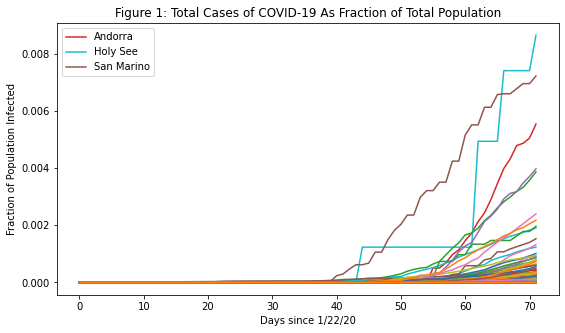

In [44]:
plotSpread([], fig=1)

***Figure 1*** (*above*): The fraction of population infected for every country in the world.

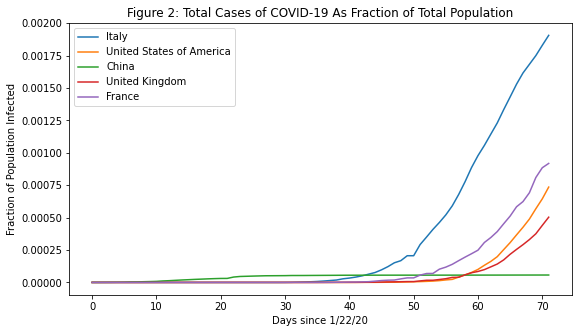

In [45]:
plotSpread(["Italy", "United States of America", "China", "United Kingdom", "France"], fig=2)

***Figure 2*** (*above*): The fraction of population infected in Italy, The United States, China, The United Kingdom, and France.


It is clear that, when plotting the growth curves as fractions of total population, Italy is experiencing a far more severe magnitude of COVID-19 cases than the United States.

### Plotting Relative Growth Curves <a class="anchor" id="9b"></a>

This is where things get very interesting. Relative Growth Curves allow us to understand much more about the spread of COVID-19 than merely plotting the fraction of the total population.

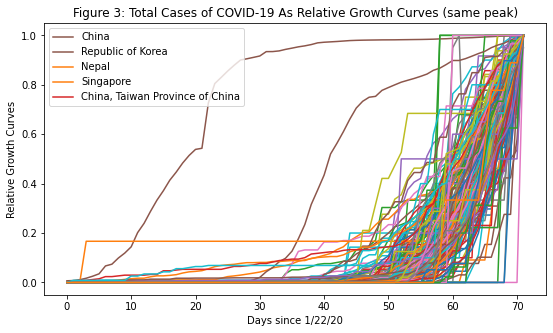

In [46]:
plotSpread([], normalizeCurves=True, title="Total Cases of COVID-19 As Relative Growth Curves (same peak)", 
           maxLabels=5, fig=3)

***Figure 3*** (*above*): The relative growth curve for every country in the world. Although this plot may seem chaotic, it sheds very important light on the global penetration of COVID-19.

From this graph, we can clearly see that **very few countries have successfully dampened the growth of COVID-19**. In particular, China, Republic of Korea (South Korea), and Nepal have dampened the growth of COVID-19 substantially. Nearly every other country has experienced untamed exponentially rapid growth of COVID-19 after day 50.

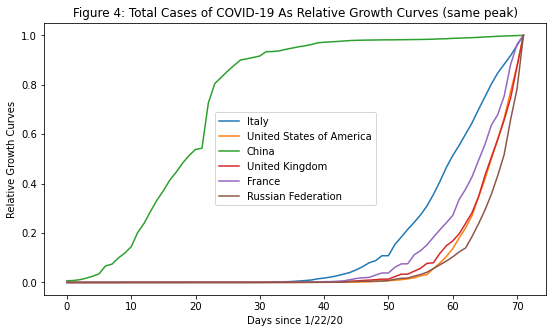

In [47]:
plotSpread(["Italy", "United States of America", "China", "United Kingdom", "France", "Russian Federation"], 
           normalizeCurves=True, title="Total Cases of COVID-19 As Relative Growth Curves (same peak)", fig=4)

***Figure 4*** (*above*): The relative growth rates of Italy, The United States, China, The United Kingdom, and France.

Clearly, China experienced the first major wave of COVID-19. Subsequently, China's growth curve has nearly leveled out. Let's more closely examine the countries in that list other than China.

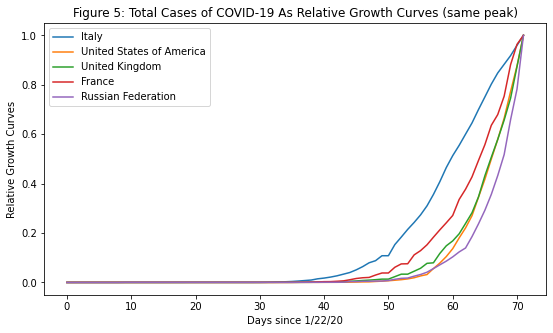

In [48]:
plotSpread(["Italy", "United States of America", "United Kingdom", "France", "Russian Federation"], 
           normalizeCurves=True, title="Total Cases of COVID-19 As Relative Growth Curves (same peak)", fig=5)

***Figure 5*** (*above*): The relative growth rates of Italy, The United States, The United Kingdom, and France.

Although these countries all have seemingly similar relative growth curves, when examined more closely, it is alarming how quickly the United States has overtaken the rest since day 55.